# Análise do Dataset Scielo

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
from multiprocessing import Pool

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from funcoes import limpa_html
from nlp_funcoes import token_lemma, add_bigram, create_dictionary, create_corpus, ModelLDA, calc_coherence

## Leitura do dataset

In [2]:
# muda o diretório atual para a pasta code onde temos o dataset salvo
os.chdir("../code")
os.getcwd()

'D:\\OneDrive\\monografia\\code'

In [3]:
df = pd.read_feather('scielo_dataset.feather')

In [4]:
df = df.query('ano > 2014')

## Limpeza do dataset

In [5]:
with Pool() as pool:
    textos = list(tqdm(pool.imap(limpa_html, df['text_html']), total=len(df)))

  0%|          | 0/810 [00:00<?, ?it/s]

## Análise dos Dados

### Tokenize and Lemma

In [6]:
with Pool() as pool:
    documentos = list(tqdm(pool.imap(token_lemma, textos), total=len(textos)))

  0%|          | 0/810 [00:00<?, ?it/s]

### Bigram, dicionário e corpus

In [7]:
add_bigram(documentos, min_count=1)
dicionario = create_dictionary(documentos, no_below=10, no_above=0.8)
corpus = create_corpus(dicionario, documentos)

### Modelo LDA

In [8]:
temp = dicionario[0]
id2word = dicionario.id2token

In [9]:
lda = ModelLDA(corpus, id2word)

### GridSearch no número de tópicos

In [10]:
n_topicos = list(range(6, 21))
with Pool(processes=9) as pool:
    modelos = list(tqdm(pool.imap(lda.run, n_topicos), total=len(n_topicos)))

  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
coerencias = {'u_mass': [],
              'c_v': [],
              'c_uci': [],
              'c_npmi': []}

for modelo in tqdm(modelos):
    for coe in tqdm(coerencias.keys(), leave=False):
        coerencias[coe].append(calc_coherence(modelo, documentos, dicionario, corpus, coe))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Gráfico das coerências

In [12]:
def plot_coerencias(coerencias):
    fig, ax = plt.subplots(nrows=1, ncols=len(coerencias),
                           figsize=(5*len(coerencias), 5))

    for i, k in enumerate(coerencias):
        y = coerencias[k]

        ax[i].set_title(k)
        ax[i].set_xlabel('Número de tópicos')

        ax[i].scatter(n_topicos, y, s=16, c='black')
        ax[i].plot(n_topicos, y, c='black', ls='--')

    fig.tight_layout()
    plt.show()

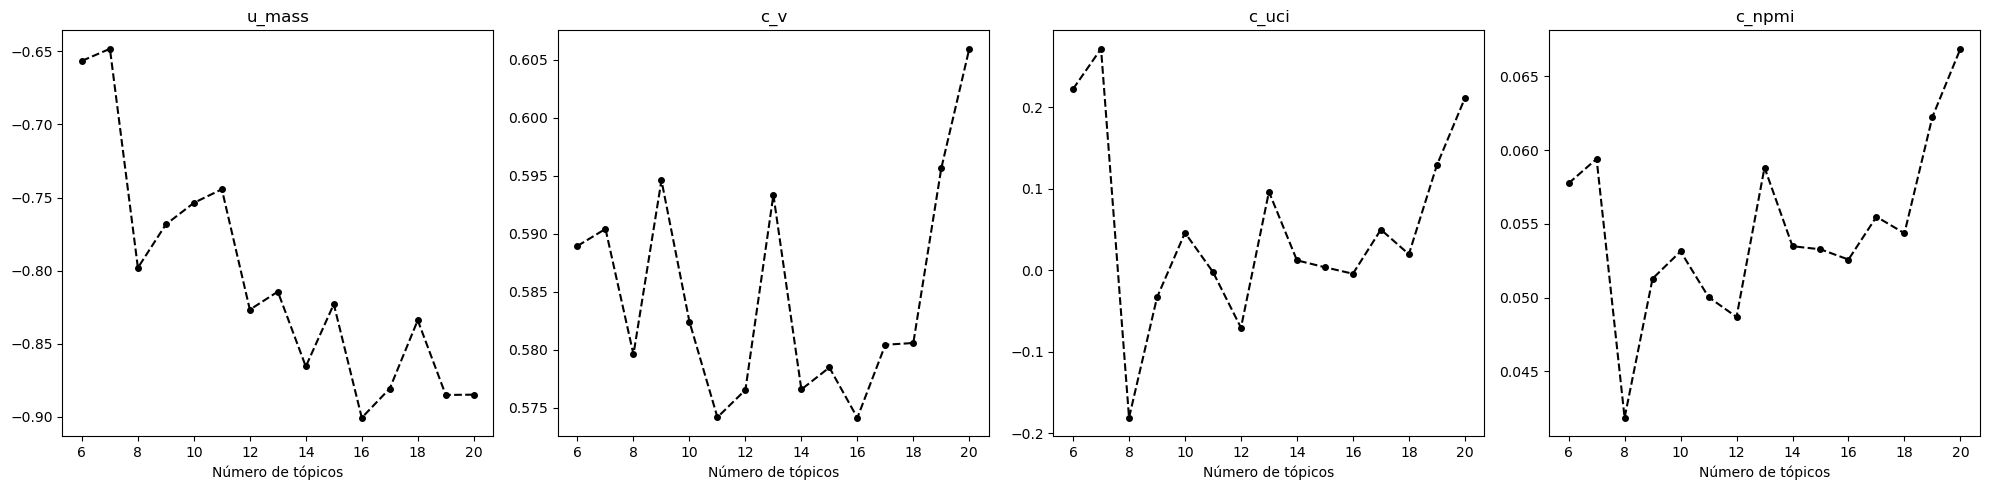

In [13]:
plot_coerencias(coerencias)

### Normalização das coerências 

In [14]:
norm_coerencias = {}
for k, v in coerencias.items():
    x = np.array(v)
    norm_coerencias[k] = (x - min(x)) / (max(x) - min(x))

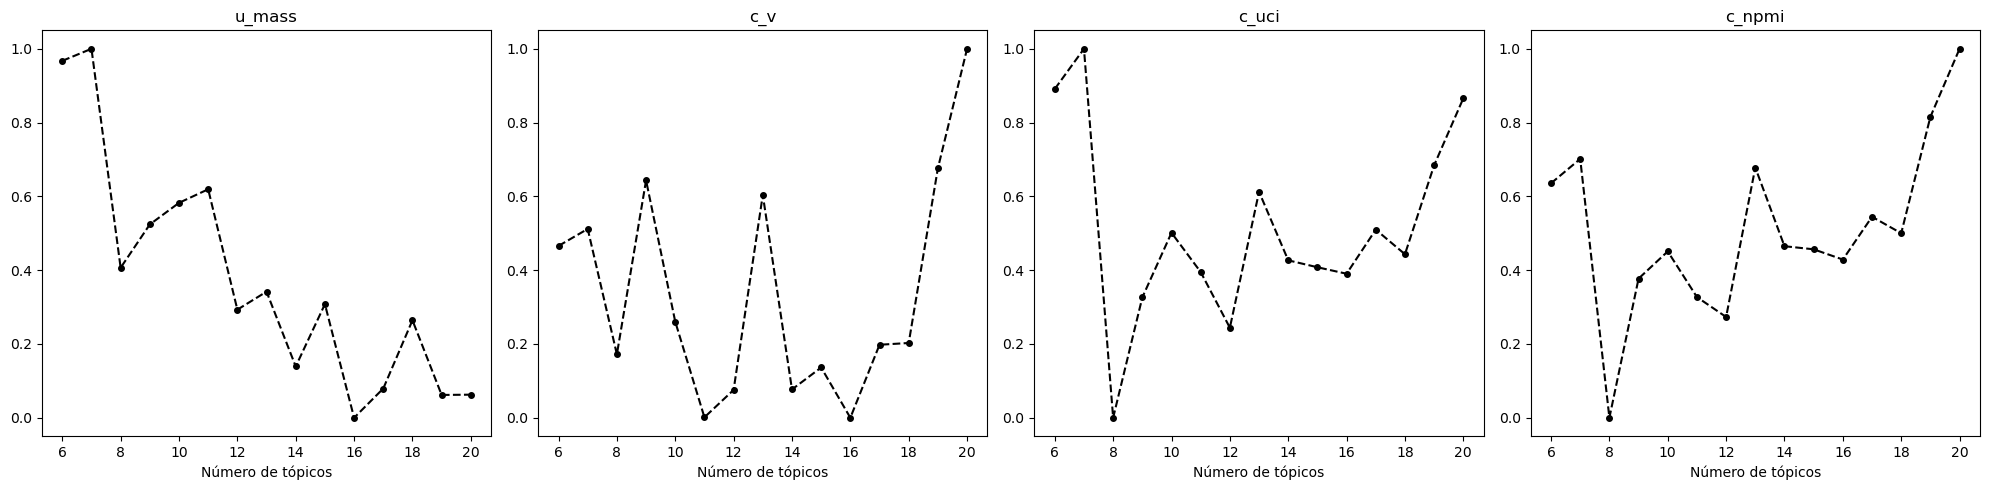

In [15]:
plot_coerencias(norm_coerencias)

In [16]:
medias = sum(norm_coerencias.values()) / len(norm_coerencias)

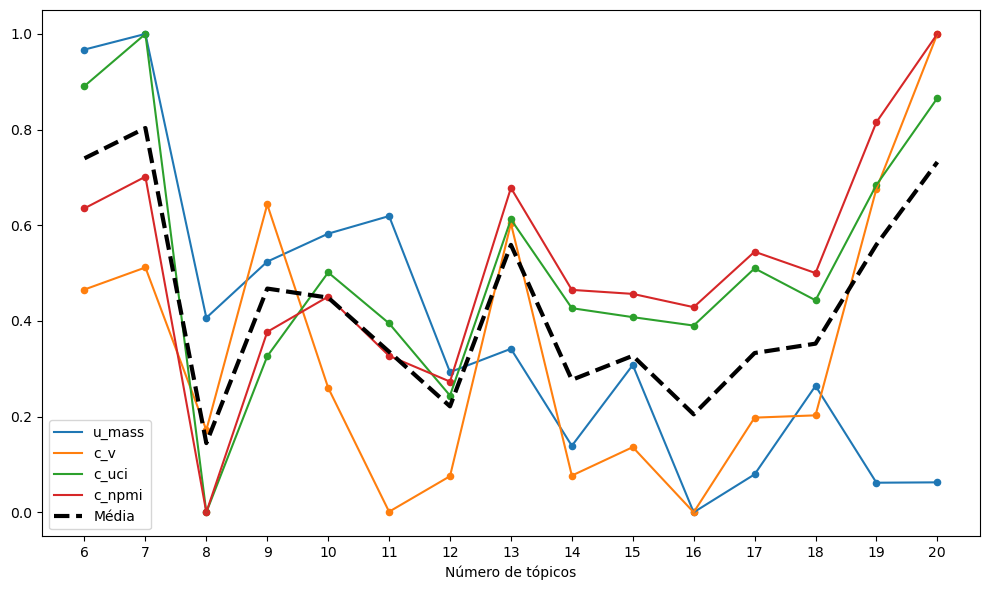

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Número de tópicos')

for i, k in enumerate(norm_coerencias):
    y = norm_coerencias[k]
    ax.scatter(n_topicos, y, s=20)
    ax.plot(n_topicos, y, label=k)

ax.plot(n_topicos, medias, label='Média', c='k', lw=3, ls='--')

ax.set_xticks(n_topicos)
ax.legend()
fig.tight_layout()
plt.show()

In [18]:
for i in medias.argsort()[::-1]:
    print(f'{str(n_topicos[i]).rjust(2, "0")} tópicos | {medias[i]:.2f}')

07 tópicos | 0.80
06 tópicos | 0.74
20 tópicos | 0.73
19 tópicos | 0.56
13 tópicos | 0.56
09 tópicos | 0.47
10 tópicos | 0.45
18 tópicos | 0.35
11 tópicos | 0.34
17 tópicos | 0.33
15 tópicos | 0.33
14 tópicos | 0.28
12 tópicos | 0.22
16 tópicos | 0.20
08 tópicos | 0.14


## Número de tópicos = 20

In [ ]:
model = lda.run(20)

In [ ]:
model.print_topics(num_words=15)

In [ ]:
df['topico'] = [max(model.get_document_topics(corpu), key=lambda x: x[1])[0] for corpu in corpus]

In [22]:
df['topico'].value_counts()

2    191
5    174
0    136
1     86
3     84
6     73
4     66
Name: topico, dtype: int64

In [23]:
pd.crosstab(df['seção'], df['topico'])

topico,0,1,2,3,4,5,6
seção,,,,,,,
ano internacional da luz,0,2,0,0,0,0,4
articles,1,2,3,0,1,2,3
artigos gerais,10,55,73,48,45,146,4
carta ao editor,2,0,0,0,0,0,0
cartas ao editor,8,0,0,1,2,0,1
desenvolvimento em ensino de física,11,1,10,0,2,1,0
didactic resources,1,2,1,0,0,0,0
errata,0,0,0,0,0,1,1
história da física e ciências afins,2,9,3,10,5,4,33
